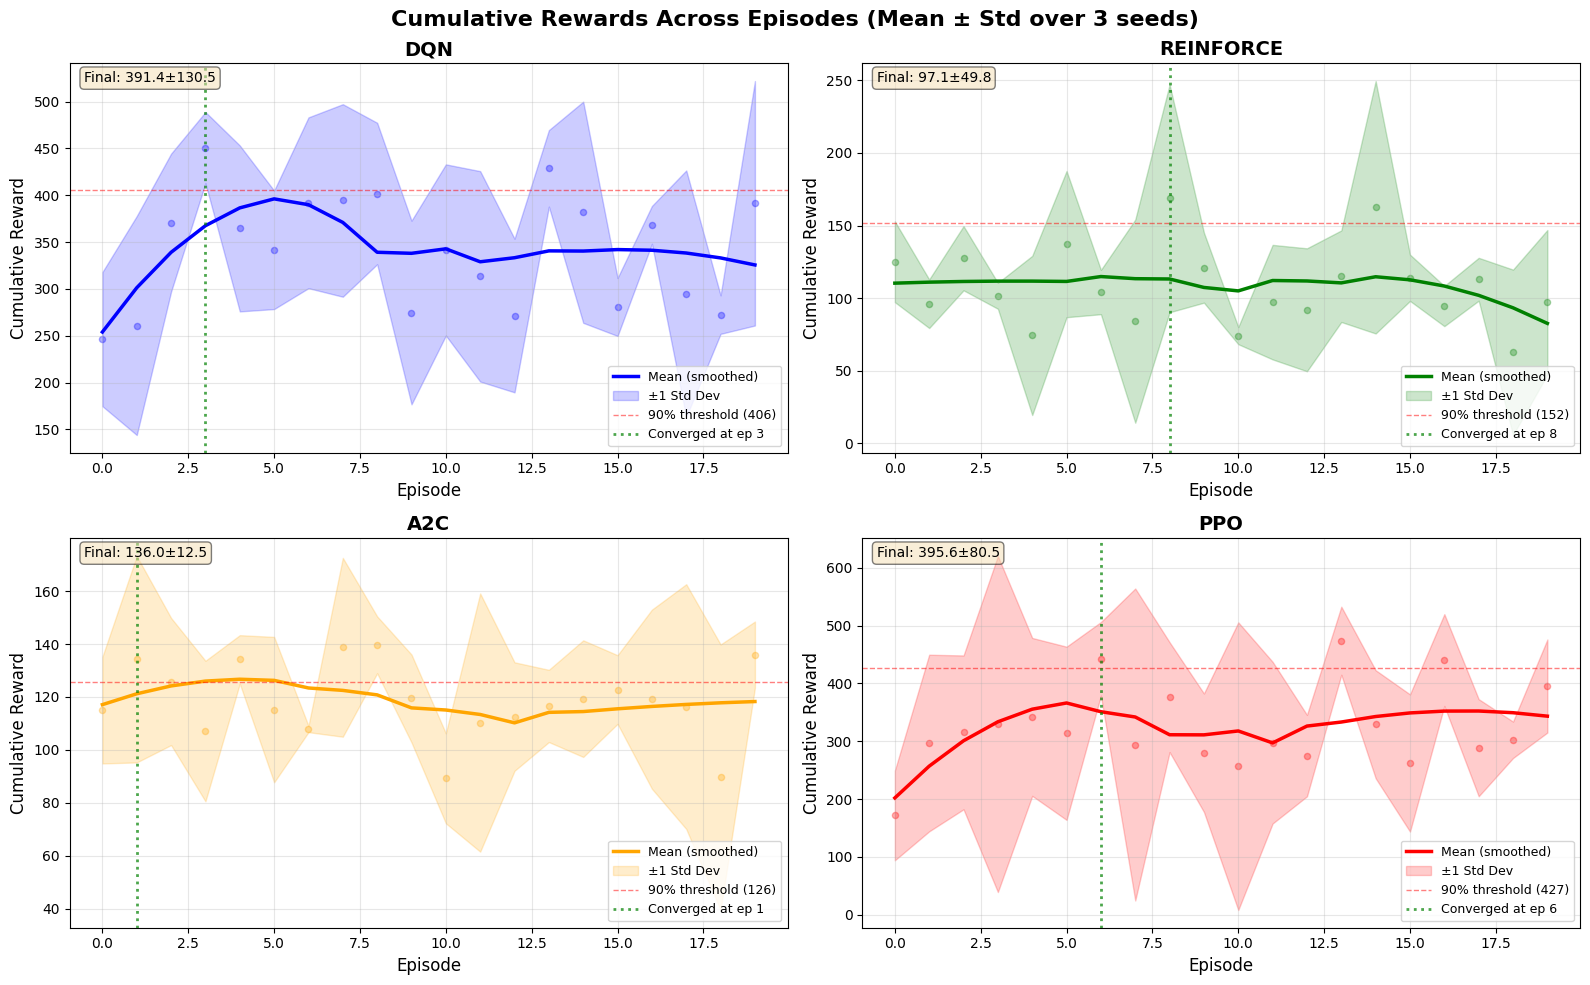

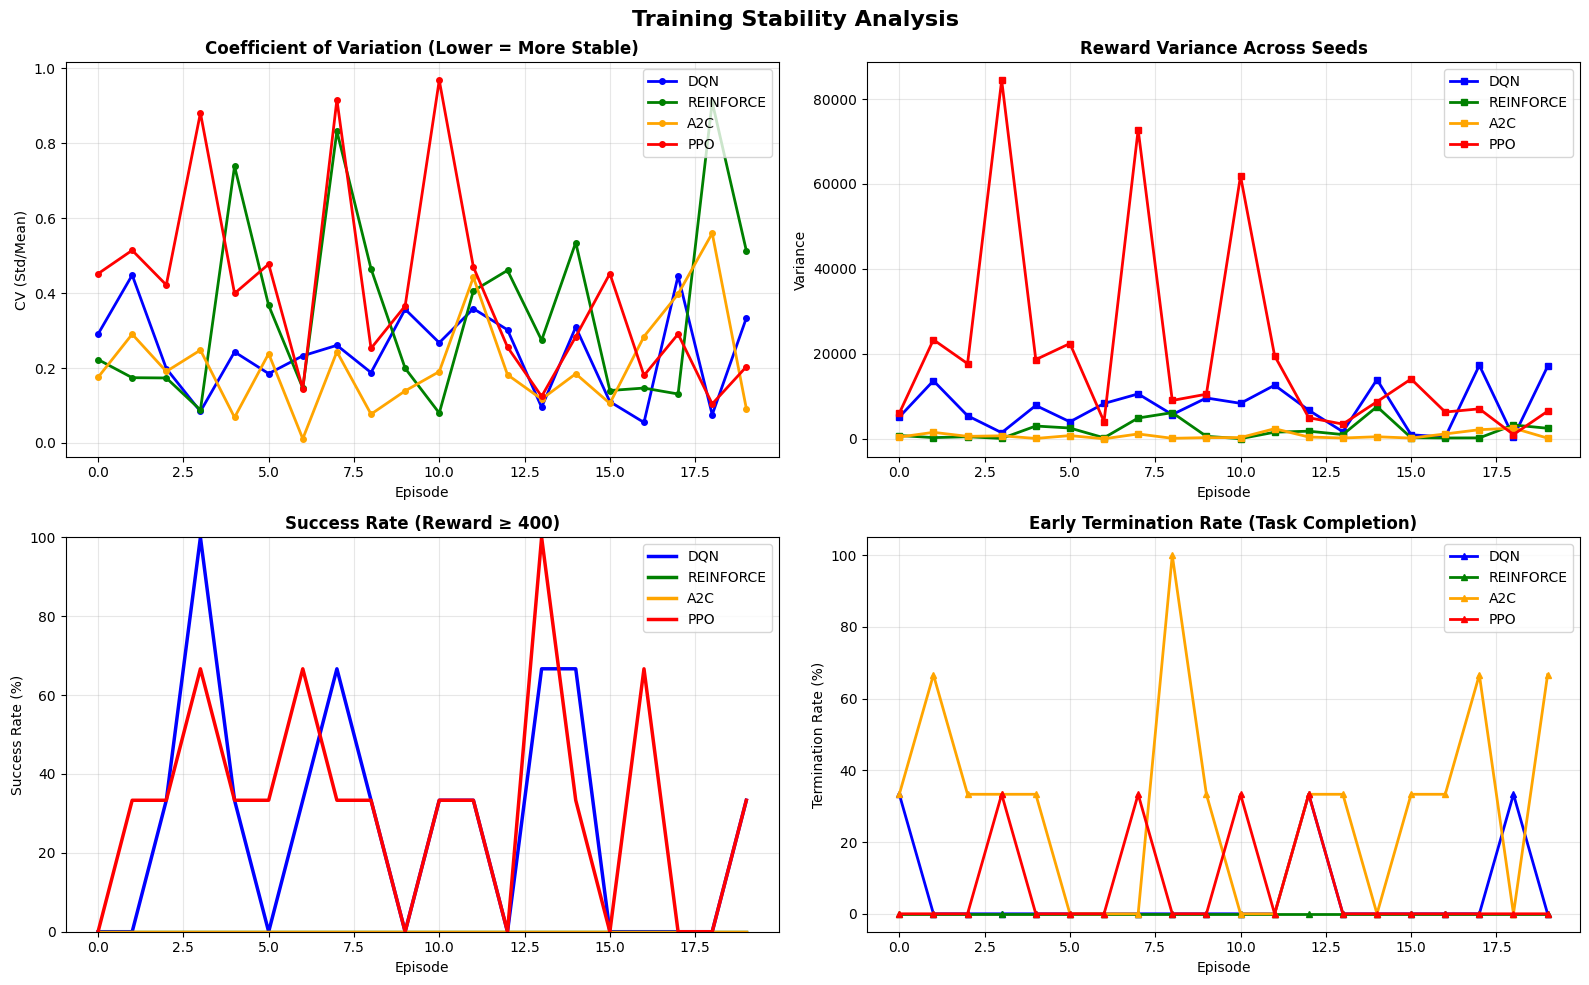

/tmp/ipykernel_1147532/4046712980.py:184: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(final_data, labels=labels, patch_artist=True,


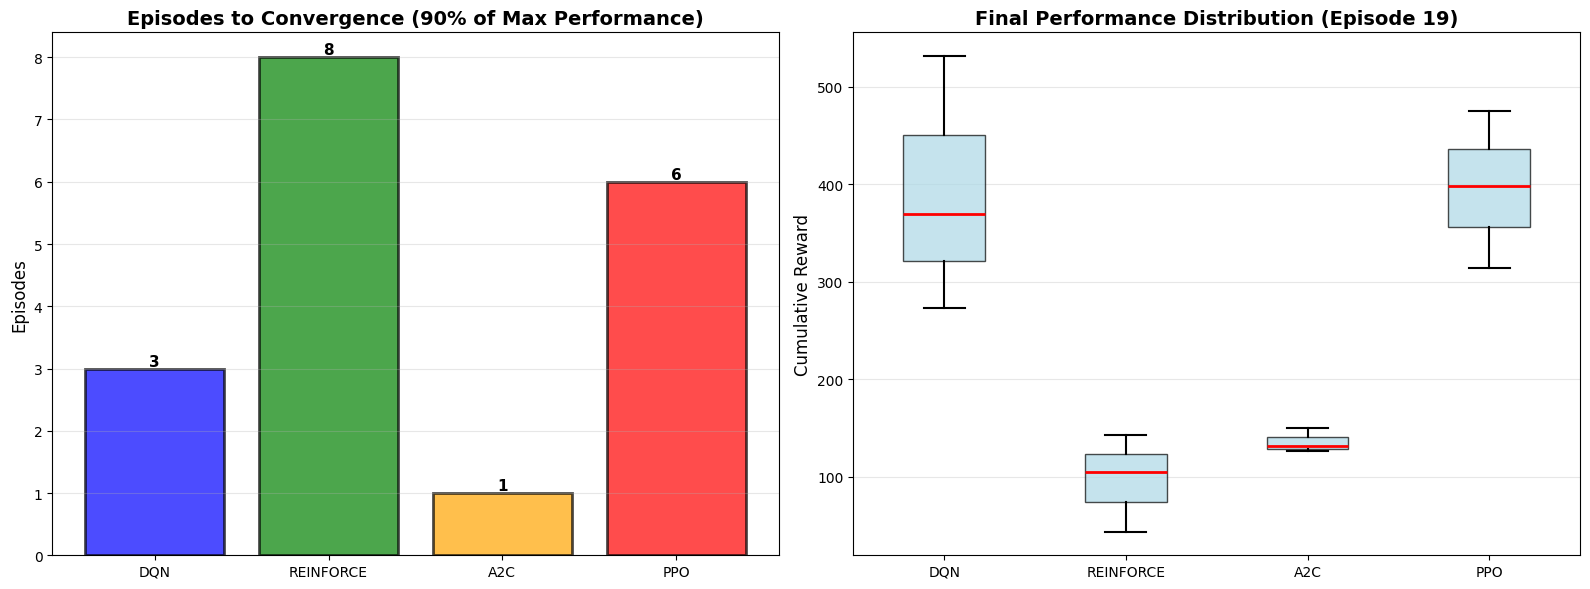


QUANTITATIVE PERFORMANCE SUMMARY

DQN:
  Final Performance:    391.43 ± 130.53
  Best Performance:     450.92
  Worst Performance:    246.34
  Improvement:          58.9%
  Converged at Episode: 3

REINFORCE:
  Final Performance:    97.09 ± 49.84
  Best Performance:     168.70
  Worst Performance:    62.65
  Improvement:          55.0%
  Converged at Episode: 8

A2C:
  Final Performance:    136.01 ± 12.49
  Best Performance:     139.69
  Worst Performance:    89.25
  Improvement:          52.4%
  Converged at Episode: 1

PPO:
  Final Performance:    395.59 ± 80.51
  Best Performance:     473.91
  Worst Performance:    171.75
  Improvement:          130.3%
  Converged at Episode: 6



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# Load data
reinforce_df = pd.read_csv("evaluate/results/reinforce_eval_results.csv")
ppo_df = pd.read_csv("evaluate/results/ppo_eval_results.csv")
dqn_df = pd.read_csv("evaluate/results/dqn_results.csv")
a2c_df = pd.read_csv("evaluate/results/a2c_eval_results.csv")

# ============================================================================
# FIGURE 1: CUMULATIVE REWARDS WITH STATISTICAL SIGNIFICANCE
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Cumulative Rewards Across Episodes (Mean ± Std over 3 seeds)', 
             fontsize=16, fontweight='bold')

algorithms = [
    ('DQN', dqn_df, axes[0, 0], 'blue'),
    ('REINFORCE', reinforce_df, axes[0, 1], 'green'),
    ('A2C', a2c_df, axes[1, 0], 'orange'),
    ('PPO', ppo_df, axes[1, 1], 'red')
]

convergence_stats = {}

for name, df, ax, color in algorithms:
    # Group by episode (within each seed) and calculate statistics
    stats = df.groupby('episode')['reward'].agg(['mean', 'std', 'count'])
    episodes = stats.index
    mean_reward = stats['mean'].values
    std_reward = stats['std'].values
    
    # Smooth the curve for better visualization
    if len(mean_reward) > 5:
        smoothed_mean = savgol_filter(mean_reward, 
                                      window_length=min(11, len(mean_reward)//2*2+1), 
                                      polyorder=2)
    else:
        smoothed_mean = mean_reward
    
    # Plot mean with confidence interval
    ax.plot(episodes, smoothed_mean, color=color, linewidth=2.5, label='Mean (smoothed)')
    ax.fill_between(episodes, 
                    mean_reward - std_reward, 
                    mean_reward + std_reward,
                    color=color, alpha=0.2, label='±1 Std Dev')
    ax.scatter(episodes, mean_reward, color=color, alpha=0.3, s=20)
    
    # Add horizontal line for convergence threshold (e.g., 90% of max mean)
    convergence_threshold = 0.9 * np.max(mean_reward)
    ax.axhline(y=convergence_threshold, color='red', linestyle='--', 
               linewidth=1, alpha=0.5, label=f'90% threshold ({convergence_threshold:.0f})')
    
    # Calculate episodes to convergence
    converged_episodes = episodes[mean_reward >= convergence_threshold]
    if len(converged_episodes) > 0:
        first_convergence = converged_episodes[0]
        convergence_stats[name] = first_convergence
        ax.axvline(x=first_convergence, color='green', linestyle=':', 
                  linewidth=2, alpha=0.7, label=f'Converged at ep {first_convergence}')
    else:
        convergence_stats[name] = None
    
    # Formatting
    ax.set_title(f'{name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Cumulative Reward', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right', fontsize=9)
    
    # Add final performance text
    final_mean = mean_reward[-1]
    final_std = std_reward[-1]
    ax.text(0.02, 0.98, f'Final: {final_mean:.1f}±{final_std:.1f}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('1_cumulative_rewards_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# FIGURE 2: TRAINING STABILITY ANALYSIS
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Training Stability Analysis', fontsize=16, fontweight='bold')

# 2.1: Coefficient of Variation (CV) over time
ax1 = axes[0, 0]
for name, df, _, color in algorithms:
    cv_per_episode = df.groupby('episode')['reward'].agg(lambda x: x.std() / x.mean() if x.mean() != 0 else 0)
    ax1.plot(cv_per_episode.index, cv_per_episode.values, 
             label=name, linewidth=2, marker='o', markersize=4, color=color)

ax1.set_title('Coefficient of Variation (Lower = More Stable)', fontweight='bold')
ax1.set_xlabel('Episode')
ax1.set_ylabel('CV (Std/Mean)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2.2: Variance over time
ax2 = axes[0, 1]
for name, df, _, color in algorithms:
    variance = df.groupby('episode')['reward'].var()
    ax2.plot(variance.index, variance.values, 
             label=name, linewidth=2, marker='s', markersize=4, color=color)

ax2.set_title('Reward Variance Across Seeds', fontweight='bold')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 2.3: Success Rate (episodes that reached certain threshold)
ax3 = axes[1, 0]
threshold = 400  # Define what "success" means
for name, df, _, color in algorithms:
    success_rate = df.groupby('episode')['reward'].apply(lambda x: (x >= threshold).sum() / len(x) * 100)
    ax3.plot(success_rate.index, success_rate.values, 
             label=name, linewidth=2.5, color=color)

ax3.set_title(f'Success Rate (Reward ≥ {threshold})', fontweight='bold')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Success Rate (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim([0, 100])

# 2.4: Termination Analysis
ax4 = axes[1, 1]
for name, df, _, color in algorithms:
    termination_rate = df.groupby('episode')['terminated'].mean() * 100
    ax4.plot(termination_rate.index, termination_rate.values, 
             label=name, linewidth=2, marker='^', markersize=4, color=color)

ax4.set_title('Early Termination Rate (Task Completion)', fontweight='bold')
ax4.set_xlabel('Episode')
ax4.set_ylabel('Termination Rate (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('2_training_stability.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# FIGURE 3: CONVERGENCE COMPARISON
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 3.1: Bar chart of episodes to convergence
ax1 = axes[0]
methods = list(convergence_stats.keys())
episodes = [convergence_stats[m] if convergence_stats[m] is not None else 20 
            for m in methods]
colors_conv = ['blue', 'green', 'orange', 'red']

bars = ax1.bar(methods, episodes, color=colors_conv, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_title('Episodes to Convergence (90% of Max Performance)', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('Episodes', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, ep in zip(bars, episodes):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(ep)}' if ep < 20 else 'No Conv.',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3.2: Final performance comparison (boxplot)
ax2 = axes[1]
final_episode = 19  # Last episode
final_data = []
labels = []

for name, df, _, _ in algorithms:
    final_rewards = df[df['episode'] == final_episode]['reward'].values
    final_data.append(final_rewards)
    labels.append(name)

bp = ax2.boxplot(final_data, labels=labels, patch_artist=True,
                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5))

ax2.set_title('Final Performance Distribution (Episode 19)', 
              fontsize=14, fontweight='bold')
ax2.set_ylabel('Cumulative Reward', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('3_convergence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# PRINT QUANTITATIVE SUMMARY
# ============================================================================
print("\n" + "="*70)
print("QUANTITATIVE PERFORMANCE SUMMARY")
print("="*70)

for name, df, _, _ in algorithms:
    stats = df.groupby('episode')['reward'].agg(['mean', 'std'])
    final_mean = stats['mean'].iloc[-1]
    final_std = stats['std'].iloc[-1]
    max_mean = stats['mean'].max()
    min_mean = stats['mean'].min()
    convergence_ep = convergence_stats.get(name, 'Did not converge')
    
    print(f"\n{name}:")
    print(f"  Final Performance:    {final_mean:.2f} ± {final_std:.2f}")
    print(f"  Best Performance:     {max_mean:.2f}")
    print(f"  Worst Performance:    {min_mean:.2f}")
    print(f"  Improvement:          {((final_mean - min_mean) / min_mean * 100):.1f}%")
    print(f"  Converged at Episode: {convergence_ep}")
    
print("\n" + "="*70)